This notebook shows how to use LLM-Geo, you can uncomment a study case (preferred Case 1 and Case 3) to get the spatial analysis results without any human intervention. 

Please check the [webpage of LLM-Geo](https://github.com/gladcolor/LLM-Geo) for more detail!


#  Install package

In [1]:
! pip install pyvis
! pip install networkx
! pip install openai

# Import package

In [2]:
!pip install pandas 

In [2]:
!pip install geopandas

In [2]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
from openai import OpenAI
from IPython.display import display, HTML, Code
from IPython.display import clear_output

In [4]:
import os
import vertexai
from vertexai.generative_models import GenerativeModel

# Define Solution class
Please run the following cell to define the functions

In [5]:
%load_ext autoreload
%autoreload 2

import LLM_Geo_Constants as constants
import helper

from LLM_Geo_kernel import Solution



# Demonstration Cases

## Input task and data desciption

In [7]:
isReview = True

In [6]:

# Case 1: population living near hazardous wastes

task_name ='Resident_at_risk_counting'
TASK = r"""1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please draw all polygons, not only the highlighted ones. The map size is 15*10 inches.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
                  "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip. The tract ID column is 'GEOID', data types is integer.",
                  "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID', data types is integer."
                 ]
 


# # Case 3: COVID-19 death rate in US
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a choropleth map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red. Set figure size to 15*10 inches.  
# '''


# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'; map projection is EPSG:4269",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]



# # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


## Case 5: Census API
# task_name ='Census_API'
# TASK = r''' Show the spatial distribution of the county level median income in the contigous US. Set figure size to (25,15)
# '''

# DATA_LOCATIONS = [
#       "You can use the Census API.",
# ]

# DATA_LOCATIONS = [
# '''Census API key: ae7be70727932dd6aed257692de3f344365d0678'''              
# ]


# # Case 2: France_mobility_changes_2020  (NOTE: invalidated due to API shutdown)
# task_name ='France_mobility_changes_2020'
# TASK = r'''
# 1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range (color scheme: coolwarm). The base of the change rate is January 2020. 
# 2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
# '''

# DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
#                   "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
#                   "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
#                   "REST API url with parameters for daily human mobility data access:" + \
#                   "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
#                   "The response is in CSV format. There are three columns in the response: " + \
#                   "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country;" + \
#                   "codes for France administrative regions start with 'FRA'. Use the total intra_movement of the month as the montly mobility.",
#                  ]


save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-4"
# model = "gemini-1.5-flash-002"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and programmer good at Python. You have worked on Geographic information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. You know well how to set up workflows for spatial analysis tasks. You have significant experence on graph theory, application, and implementation. You are also experienced on generating map using Matplotlib and GeoPandas.
 

Your task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please d

## Get graph code from GPT API

In [45]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))


# response_for_graph = solution.get_LLM_response_for_graph()
# solution.save_solution()

# # Load solution
# loaded_solution = load_solution("./task1.pkl")
# print(loaded_solution.task_name)  # Should print "task1"

import networkx as nx


 G = nx.DiGraph()


 # Data Nodes
 G.add_node("nc_haz_waste_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip", description="NC hazardous waste facility shapefile URL")
 G.add_node("nc_tract_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip", description="NC tract boundary shapefile URL")
 G.add_node("nc_tract_pop_csv_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv", description="NC tract population CSV file URL")


 # Operation Nodes and Edges
 G.add_node("load_haz_waste_shp", node_type="operation", description="Load hazardous waste facility shapefile")
 G.add_edge("nc_haz_waste_shp_url", "load_haz_waste_shp")
 G.add_node("haz_waste_gdf", node_type="data", description="Hazardous waste facility GeoDataFrame")
 G.add_edge("load_haz_waste_shp", "haz_waste_gdf")


 G.add_node("load_tract_shp", node_type="operation", description="Load NC tract boundary shapefile")
 G.add_edge("nc_tract_shp_url", "load_tract_shp")
 G.add_node("tract_gdf", node_type="data", description="NC tract boundary GeoDataFrame")
 G.add_edge("load_tract_shp", "tract_gdf")


 G.add_node("load_tract_pop", node_type="operation", description="Load NC tract population data")
 G.add_edge("nc_tract_pop_csv_url", "load_tract_pop")
 G.add_node("tract_pop_df", node_type="data", description="NC tract population DataFrame")
 G.add_edge("load_tract_pop", "tract_pop_df")


 G.add_node("spatial_join", node_type="operation", description="Perform spatial join between tract and hazardous waste data")
 G.add_edge("tract_gdf", "spatial_join")
 G.add_edge("haz_waste_gdf", "spatial_join")
 G.add_node("joined_gdf", node_type="data", description="GeoDataFrame with tract boundaries and hazardous waste information")
 G.add_edge("spatial_join", "joined_gdf")


 G.add_node("filter_tracts", node_type="operation", description="Filter tracts containing hazardous waste facilities")
 G.add_edge("joined_gdf", "filter_tracts")
 G.add_node("haz_waste_tracts_gdf", node_type="data", description="GeoDataFrame of tracts containing hazardous waste")
 G.add_edge("filter_tracts", "haz_waste_tracts_gdf")


 G.add_node("join_pop_data", node_type="operation", description="Join population data to tracts with hazardous waste")
 G.add_edge("haz_waste_tracts_gdf", "join_pop_data")
 G.add_edge("tract_pop_df", "join_pop_data")
 G.add_node("pop_in_haz_tracts_df", node_type="data", description="DataFrame with population in tracts containing hazardous waste")
 G.add_edge("join_pop_data", "pop_in_haz_tracts_df")


 G.add_node("calculate_total_pop", node_type="operation", description="Calculate total population in tracts with hazardous waste")
 G.add_edge("pop_in_haz_tracts_df", "calculate_total_pop")
 G.add_node("total_pop_haz_waste", node_type="data", description="Total population in tracts with hazardous waste")
 G.add_edge("calculate_total_pop", "total_pop_haz_waste")


 G.add_node("create_choropleth_map", node_type="operation", description="Generate population choropleth map, highlighting tracts with hazardous waste")
 G.add_edge("tract_gdf", "create_choropleth_map")
 G.add_edge("tract_pop_df", "create_choropleth_map")
 G.add_edge("haz_waste_tracts_gdf", "create_choropleth_map")
 G.add_node("choropleth_map", node_type="data", description="Generated choropleth map")
 G.add_edge("create_choropleth_map", "choropleth_map")




 #Save the graph to GraphML file
 nx.write_graphml(G, "C:\\Users\\chait\\Projects\\LLM_Geo_GCP\\Resident_at_risk_counting\\Resident_at_risk_counting.graphml")

## Execute code to generate the solution graph

In [9]:
import textwrap
import os

# Step 1: Get the response and save it
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

# Step 2: Normalize the code to fix indentation
try:
    # Normalize the indentation
    normalized_code = textwrap.dedent(solution.code_for_graph)
    
    # Debugging: Print the normalized code
    print("Normalized code for graph:\n", normalized_code)
    
    # Save the normalized code to a temporary file (optional, for debugging)
    debug_file = "debug_generated_code.py"
    with open(debug_file, "w") as f:
        f.write(normalized_code)
    print(f"Normalized code saved to: {os.path.abspath(debug_file)}")
    
    # Step 3: Execute the normalized code
    exec(normalized_code)
except IndentationError as e:
    print(f"IndentationError in generated code: {e}")
except Exception as e:
    print(f"Error executing the generated code: {e}")

Attempt 1: Generating response...

Response:
```python
import networkx as nx

G = nx.DiGraph()

# Input Data Nodes
G.add_node("nc_tract_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip", description="North Carolina tract boundary shapefile URL")
G.add_node("nc_hazwaste_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip", description="North Carolina hazardous waste sites shapefile URL")
G.add_node("nc_tract_pop_csv_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv", description="North Carolina tract population CSV file URL")


# Operation Nodes and Data Nodes
G.add_node("load_tract_shp", node_type="operation", description="Load North Carolina tract shapefile")
G.add_edge("nc_tract_shp_url", "load_tract_shp")
G.add_node("tract_gdf", node_type="data", data_path="", d

In [58]:
file_path = "debugged_graph_code.py"

# Read the file content
with open(file_path, "r") as file:
    debugged_code = file.read()

# Store the code into solution.code_for_graph
solution.code_for_graph = debugged_code

exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# # HTML file should in the same directory. See:
# # https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
# nt.show(name=html_name)
# # html_name

C:\Users\chait\Projects\LLM_Geo_GCP\Resident_at_risk_counting.html


## Generate prompts and code for operations (functions)

In [10]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd
import pandas as pd

def load_tract_shp(NC_tract_boundary_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip'):
    """Load North Carolina tract shapefile"""
    NC_tracts_gdf = gpd.read_file(NC_tract_boundary_shp_url)
    return NC_tracts_gdf
import geopandas as gpd
import pandas as pd

def load_hazwaste_shp(NC_hazwaste_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    """Load North Carolina hazardous waste shapefile"""
    NC_hazwaste_gdf = gpd.read_file(NC_hazwaste_shp_url)
    return NC_hazwaste_gdf
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def load_tract_pop_csv(NC_tract_pop_csv_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    """Load North Carolina tract population CSV"""
    NC_tract_pop_df = pd.read_csv(NC_tract_pop_csv_url, dtype={'GEOID': str})
    NC_tract_pop_df = NC_tract_pop_df.dropna(subset=['GEOID', 'TotalPopulation'])
    return NC_tract_pop_df
import geopandas as gpd
 import pandas as pd
 

 def spatial_join(NC_tracts_gdf, NC_hazwaste_gdf):
  """Perform spatial join between tracts and hazardous waste sites"""
 

  # Ensure both GeoDataFrames use the same CRS
  NC_tracts_gdf = NC_tracts_gdf.to_crs(NC_hazwaste_gdf.crs)
 

  # Perform spatial join using 'intersects' predicate
  tracts_with_hazwaste = gpd.sjoin(NC_tracts_gdf, NC_hazwaste_gdf, how='left', predicate='intersects')
 

  # Drop unnecessary columns and handle potential NaN values
  tracts_with_hazwaste = tracts_with_hazwaste[['GEOID', 'geometry']]
  tracts_with_hazwaste = tracts_with_hazwaste.dropna(subset=['GEOID'])
  tracts_with_hazwaste = tracts_with_hazwaste.drop_duplicates(subset=['GEOID'])
  
  return tracts_with_hazwaste
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def calculate_total_pop(NC_tract_pop_df, tracts_with_hazwaste):
    """Calculate total population in tracts with hazardous waste"""
    # Ensure GEOID is string type for both DataFrames.
    NC_tract_pop_df['GEOID'] = NC_tract_pop_df['GEOID'].astype(str)
    tracts_with_hazwaste['GEOID'] = tracts_with_hazwaste['GEOID'].astype(str)
    
    # Perform join operation
    pop_in_hazwaste_tracts = pd.merge(tracts_with_hazwaste, NC_tract_pop_df, on='GEOID', how='left')
    
    # Drop rows with NaN in 'TotalPopulation'
    pop_in_hazwaste_tracts = pop_in_hazwaste_tracts.dropna(subset=['TotalPopulation'])
    
    #Compute total population
    population_in_hazwaste_tracts = pop_in_hazwaste_tracts['TotalPopulation'].sum()
    
    return population_in_hazwaste_tracts

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def create_choropleth_map(tract_gdf, tract_pop_df, tracts_with_hazwaste):
    """Generate population choropleth map, highlighting tracts with hazardous waste"""
    
    # Ensure GEOID is string type for both DataFrames.
    tract_pop_df['GEOID'] = tract_pop_df['GEOID'].astype(str)
    tract_gdf['GEOID'] = tract_gdf['GEOID'].astype(str)
    
    #Merge tract data with population data
    tract_gdf = pd.merge(tract_gdf, tract_pop_df, on='GEOID', how='left')
    tract_gdf = tract_gdf.dropna(subset=['TotalPopulation'])
    
    #Create the choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    tract_gdf.plot(column='TotalPopulation', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Population"})
    
    #Highlight tracts with hazardous waste
    tracts_with_hazwaste.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=3)
    
    ax.set_title('North Carolina Tract Population with Hazardous Waste Sites Highlighted', fontsize=16)
    ax.set_axis_off()
    plt.show()
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def create_choropleth_map(NC_tracts_gdf, NC_tract_pop_df, tracts_with_hazwaste):
    """Create population choropleth map, h

## Generate prompts and code for assembly program

In [92]:
print(solution.assembly_prompt) 

Your role: A professional Geo-information scientist and programmer good at Python. You have worked on Geographic information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. Your are very good at assembling functions and small programs together. You know how to make programs robust.
 

Your task is: use the given Python functions, return a complete Python program to solve the question: 
 1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please draw all polygons, not only the highlighted ones. The map size is 15*10 inches.
Requirement: 
 1. You can think step by step. 
2. Each function is one step to solve the question. 
3

In [86]:
# print(solution.assembly_LLM_response)

In [113]:
# assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
# solution.assembly_LLM_response = assembly_LLM_response
# solution.save_solution()

# clear_output(wait=True)
# display(Code(solution.code_for_assembly, language='python'))

In [100]:
import vertexai
from vertexai.generative_models import GenerativeModel

# TODO(developer): Update and un-comment below line
PROJECT_ID = "llmgis"
vertexai.init(project=PROJECT_ID, location="us-central1")

model = GenerativeModel("gemini-1.5-flash-002")

response = model.generate_content(
    solution.assembly_prompt
)

print(response.text)


```python
 import geopandas as gpd
 import pandas as pd
 import matplotlib.pyplot as plt
 

 def assembely_solution():
  NC_tracts_gdf = load_tract_shp()
  NC_hazwaste_gdf = load_hazwaste_shp()
  NC_tract_pop_df = load_tract_pop_csv()
  tracts_with_hazwaste = spatial_join(NC_tracts_gdf, NC_hazwaste_gdf)
  total_pop = calculate_total_pop(NC_tract_pop_df, tracts_with_hazwaste)
  print(f"Total population in census tracts containing hazardous waste facilities: {total_pop}")
  pop_choropleth_map = create_choropleth_map(NC_tracts_gdf, NC_tract_pop_df, tracts_with_hazwaste)
  plt.savefig('NC_tract_population_choropleth.png')
 

 

 ```


In [107]:
code_for_assembly = helper.extract_code(response.text)

Debug: Response object type: <class 'str'>
Debug: Response content: ```python
 import geopandas as gpd
 import pandas as pd
 import matplotlib.pyplot as plt
 

 def assembely_solution():
  NC_tracts_gdf = load_tract_shp()
  NC_hazwaste_gdf = load_hazwaste_shp()
  NC_tract_pop_df = load_tract_pop_csv()
  tracts_with_hazwaste = spatial_join(NC_tracts_gdf, NC_hazwaste_gdf)
  total_pop = calculate_total_pop(NC_tract_pop_df, tracts_with_hazwaste)
  print(f"Total population in census tracts containing hazardous waste facilities: {total_pop}")
  pop_choropleth_map = create_choropleth_map(NC_tracts_gdf, NC_tract_pop_df, tracts_with_hazwaste)
  plt.savefig('NC_tract_population_choropleth.png')
 

 

 ```


In [108]:
 code_for_assembly

'import geopandas as gpd\n import pandas as pd\n import matplotlib.pyplot as plt\n \n\n def assembely_solution():\n  NC_tracts_gdf = load_tract_shp()\n  NC_hazwaste_gdf = load_hazwaste_shp()\n  NC_tract_pop_df = load_tract_pop_csv()\n  tracts_with_hazwaste = spatial_join(NC_tracts_gdf, NC_hazwaste_gdf)\n  total_pop = calculate_total_pop(NC_tract_pop_df, tracts_with_hazwaste)\n  print(f"Total population in census tracts containing hazardous waste facilities: {total_pop}")\n  pop_choropleth_map = create_choropleth_map(NC_tracts_gdf, NC_tract_pop_df, tracts_with_hazwaste)\n  plt.savefig(\'NC_tract_population_choropleth.png\')'

In [118]:
all_code = all_operation_code_str + '\n' + code_for_assembly +  '\n' + 'assembely_solution()'

display(Code(all_code, language='python'))

import geopandas as gpd
import pandas as pd

def load_tract_shp(NC_tract_boundary_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip'):
    # Description: Load North Carolina tract shapefile
    NC_tracts_gdf = gpd.read_file(NC_tract_boundary_shp_url)
    NC_tracts_gdf = NC_tracts_gdf[['GEOID', 'geometry']]
    NC_tracts_gdf = NC_tracts_gdf.dropna()
    NC_tracts_gdf['GEOID'] = NC_tracts_gdf['GEOID'].astype(str)
    return NC_tracts_gdf
import geopandas as gpd
import pandas as pd

def load_hazwaste_shp(NC_hazwaste_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    """Load North Carolina hazardous waste shapefile"""
    NC_hazwaste_gdf = gpd.read_file(NC_hazwaste_shp_url)
    return NC_hazwaste_gdf
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def load_tract_pop_csv(NC_tract_pop_csv_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    """Load North Carolina tract population CSV"""
    NC_tract_pop_df = pd.read_csv(NC_tract_pop_csv_url, dtype={'GEOID': str})
    NC_tract_pop_df = NC_tract_pop_df.dropna(subset=['GEOID', 'TotalPopulation'])
    return NC_tract_pop_df
import geopandas as gpd
 import pandas as pd
 

 def spatial_join(NC_tracts_gdf=None, NC_hazwaste_gdf=None):
  """Perform spatial join between tracts and hazardous waste sites"""
  # Ensure both GeoDataFrames are in the same projection
  NC_hazwaste_gdf = NC_hazwaste_gdf.to_crs(NC_tracts_gdf.crs)
 

  # Perform spatial join using sjoin
  tracts_with_hazwaste = gpd.sjoin(NC_tracts_gdf, NC_hazwaste_gdf, how="left", predicate="intersects")
 

  # Drop rows with NaN in GEOID (for safety)
  tracts_with_hazwaste = tracts_with_hazwaste.dropna(subset=['GEOID'])
  
  # Remove duplicates while keeping the geometry column
  tracts_with_hazwaste = tracts_with_hazwaste.drop_duplicates(subset=['GEOID'], keep='first')
 

  return tracts_with_hazwaste
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def calculate_total_pop(NC_tract_pop_df=None, tracts_with_hazwaste=None):
    """Calculate total population in tracts with hazardous waste"""
    # Convert GEOID to string if it's not already
    if tracts_with_hazwaste['GEOID'].dtype != 'object':
        tracts_with_hazwaste['GEOID'] = tracts_with_hazwaste['GEOID'].astype(str)

    # Merge dataframes
    merged_df = pd.merge(tracts_with_hazwaste, NC_tract_pop_df, on='GEOID', how='left')
    merged_df = merged_df.dropna(subset=['TotalPopulation'])
    
    # Calculate total population
    population_in_hazwaste_tracts = merged_df['TotalPopulation'].sum()
    return population_in_hazwaste_tracts
import geopandas as gpd
 import pandas as pd
 import matplotlib.pyplot as plt
 

 def create_choropleth_map(NC_tracts_gdf=None, NC_tract_pop_df=None, tracts_with_hazwaste=None):
  """Create population choropleth map, highlighting tracts with hazardous waste"""
 

  # Merge tract data with population data
  merged_df = NC_tracts_gdf.merge(NC_tract_pop_df, on='GEOID', how='left')
  merged_df = merged_df.dropna(subset=['TotalPopulation'])
  merged_df['TotalPopulation'] = merged_df['TotalPopulation'].astype(int)
 

  # Identify tracts with hazardous waste
  tracts_with_hazwaste['GEOID'] = tracts_with_hazwaste['GEOID'].astype(str)
  merged_df['hazardous_waste'] = merged_df['GEOID'].isin(tracts_with_hazwaste['GEOID']).astype(int)
 

  # Create the choropleth map
  fig, ax = plt.subplots(1, 1, figsize=(15, 10))
  merged_df.plot(column='TotalPopulation', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Population", 'orientation': "vertical"})
  tracts_with_hazwaste.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
  ax.set_title('Population Choropleth Map of NC Tracts with Hazardous Waste Highlighted')
  ax.set_axis_off()
  pop_choropleth_map = fig
  return pop_choropleth_map
import geopandas as gpd
 impor

In [125]:
all_code = """import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def load_tract_shp(NC_tract_boundary_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip'):
    # Description: Load North Carolina tract shapefile
    NC_tracts_gdf = gpd.read_file(NC_tract_boundary_shp_url)
    NC_tracts_gdf = NC_tracts_gdf[['GEOID', 'geometry']]
    NC_tracts_gdf = NC_tracts_gdf.dropna()
    NC_tracts_gdf['GEOID'] = NC_tracts_gdf['GEOID'].astype(str)
    return NC_tracts_gdf

def load_hazwaste_shp(NC_hazwaste_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    # Load North Carolina hazardous waste shapefile
    NC_hazwaste_gdf = gpd.read_file(NC_hazwaste_shp_url)
    return NC_hazwaste_gdf

def load_tract_pop_csv(NC_tract_pop_csv_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    #Load North Carolina tract population CSV
    NC_tract_pop_df = pd.read_csv(NC_tract_pop_csv_url, dtype={'GEOID': str})
    NC_tract_pop_df = NC_tract_pop_df.dropna(subset=['GEOID', 'TotalPopulation'])
    return NC_tract_pop_df

def spatial_join(NC_tracts_gdf=None, NC_hazwaste_gdf=None):
    #Perform spatial join between tracts and hazardous waste sites
    # Ensure both GeoDataFrames are in the same projection
    NC_hazwaste_gdf = NC_hazwaste_gdf.to_crs(NC_tracts_gdf.crs)

    # Perform spatial join using sjoin
    tracts_with_hazwaste = gpd.sjoin(NC_tracts_gdf, NC_hazwaste_gdf, how="left", predicate="intersects")

    # Drop rows with NaN in GEOID (for safety)
    tracts_with_hazwaste = tracts_with_hazwaste.dropna(subset=['GEOID'])

    # Remove duplicates while keeping the geometry column
    tracts_with_hazwaste = tracts_with_hazwaste.drop_duplicates(subset=['GEOID'], keep='first')

    return tracts_with_hazwaste

def calculate_total_pop(NC_tract_pop_df=None, tracts_with_hazwaste=None):
    #Calculate total population in tracts with hazardous waste
    # Convert GEOID to string if it's not already
    if tracts_with_hazwaste['GEOID'].dtype != 'object':
        tracts_with_hazwaste['GEOID'] = tracts_with_hazwaste['GEOID'].astype(str)

    # Merge dataframes
    merged_df = pd.merge(tracts_with_hazwaste, NC_tract_pop_df, on='GEOID', how='left')
    merged_df = merged_df.dropna(subset=['TotalPopulation'])
    
    # Calculate total population
    population_in_hazwaste_tracts = merged_df['TotalPopulation'].sum()
    return population_in_hazwaste_tracts

def create_choropleth_map(NC_tracts_gdf=None, NC_tract_pop_df=None, tracts_with_hazwaste=None):
    #Create population choropleth map, highlighting tracts with hazardous waste#

    # Merge tract data with population data
    merged_df = NC_tracts_gdf.merge(NC_tract_pop_df, on='GEOID', how='left')
    merged_df = merged_df.dropna(subset=['TotalPopulation'])
    merged_df['TotalPopulation'] = merged_df['TotalPopulation'].astype(int)

    # Identify tracts with hazardous waste
    tracts_with_hazwaste['GEOID'] = tracts_with_hazwaste['GEOID'].astype(str)
    merged_df['hazardous_waste'] = merged_df['GEOID'].isin(tracts_with_hazwaste['GEOID']).astype(int)

    # Create the choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    merged_df.plot(column='TotalPopulation', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Population", 'orientation': "vertical"})
    tracts_with_hazwaste.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
    ax.set_title('Population Choropleth Map of NC Tracts with Hazardous Waste Highlighted')
    ax.set_axis_off()
    pop_choropleth_map = fig
    return pop_choropleth_map

def assembely_solution():
    NC_tracts_gdf = load_tract_shp()
    NC_hazwaste_gdf = load_hazwaste_shp()
    NC_tract_pop_df = load_tract_pop_csv()
    tracts_with_hazwaste = spatial_join(NC_tracts_gdf, NC_hazwaste_gdf)
    total_pop = calculate_total_pop(NC_tract_pop_df, tracts_with_hazwaste)
    print(f"Total population in census tracts containing hazardous waste facilities: {total_pop}")
    pop_choropleth_map = create_choropleth_map(NC_tracts_gdf, NC_tract_pop_df, tracts_with_hazwaste)
    plt.savefig('NC_tract_population_choropleth.png')

assembely_solution()
"""

In [ ]:
#THE LLM Debugging deviates from the original purpose of the prompt and outputs a read csv function which needs to be fixed!



-------------- Running code (trial # 1/10) --------------


Total population in census tracts containing hazardous waste facilities: 10264876


--------------- Done ---------------




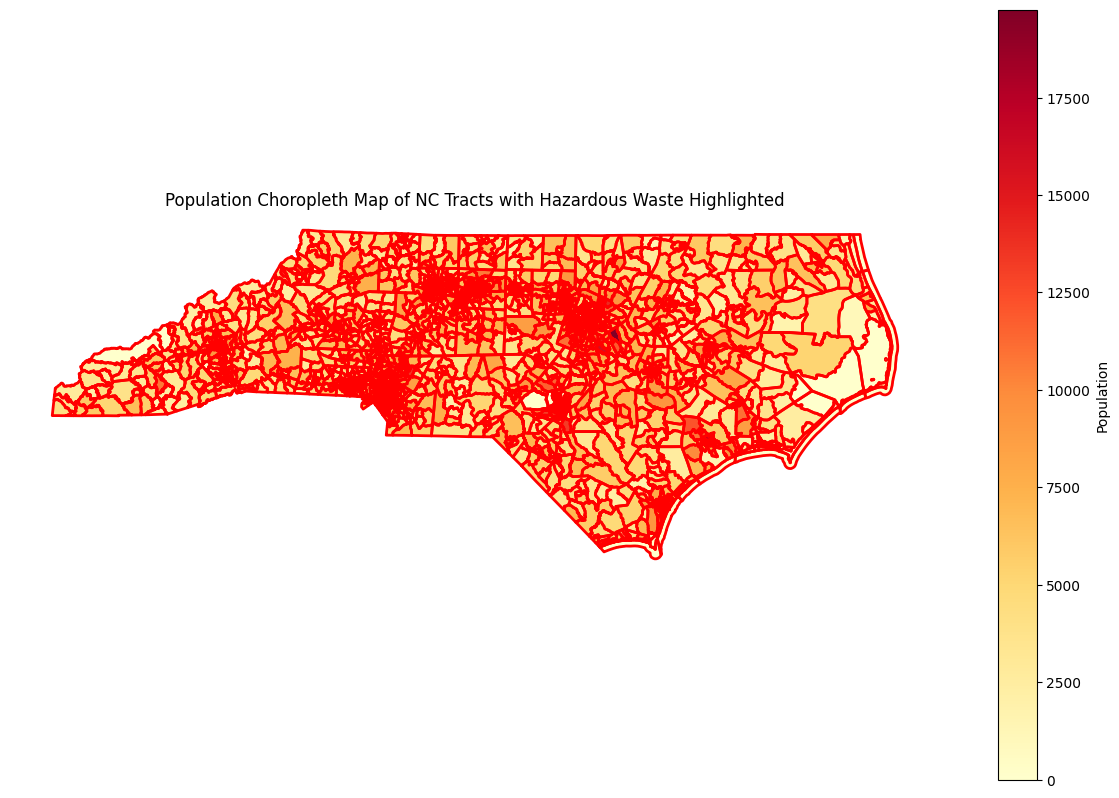

In [126]:
output=solution.execute_complete_program(code=all_code, try_cnt=10)

In [114]:
all_code = all_operation_code_str + '\n' + code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)

## Execute assembly code

In [115]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)